<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
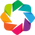

In [2]:
import base as b
import pandas as pd
import hvplot.pandas  # noqa
import datetime as dt
from typing import Dict
import talib as ta
import utils as ut
from constants import *
from scipy.stats import linregress
from logger_settings import logger
import holoviews as hv
hv.extension('bokeh')


pd.options.plotting.backend = 'holoviews'

settings = {
    "vwch_thresh": 3.2,
    "min_sig_ch": .15, # Minimum change required in direction in order to be non-retracing tick, otherwise its retracing
    "vrf": 1, # volume_retrace_factor
    "vsf": 1.5, # volume_stagnate_factor
    "up_ticks_breach": 15, # last n ticks to breach in order to count as retracel
    "down_ticks_breach": 15, # last n ticks to breach in order to count as retracel
    "up_pc_breach": 1.5,
    "down_pc_breach": 1,
    "up_tick_len_term": 15,
    "down_tick_len_term": 10,
    "up_pc_term": 2,
    "down_pc_term": 1.6,
    "quantity": 50 * 1, # 1 lot
    "stagnation_cooldown": 5, # cooldown period after stagnation to resume, in ticks
    "svs_mn_thresh": 5000, # stagnation_volume_std_max_threshold
    "svs_mx_thresh": 10000, # stagnation_volume_std_min_threshold
    "aenc": 5, # After entry cool down ticks
    "aexc": 5, # After exit cool down ticks,
    "ema_short": 25,
    "ema_long": 50,
    "ema_xshort": 15,
    "stagnation_std_thresh_up": .70,
    "stagnation_std_thresh_down": .67,
    "stagnation_std_window": 20,
}

instrument = b.Instrument(name="NIFTY 22650 CALL 7 Mar 2024")

SYMBOL = "NIFTY"
expiry = dt.datetime.strptime("2024-03-21", "%Y-%m-%d").date()
otype = "CE"
strike = 22000
date = dt.datetime.strptime("2024-03-15", "%Y-%m-%d").date()

tdf = ut.get_ticks(symbol=SYMBOL, expiry=expiry, strike=strike, otype=otype, date=date)

In [3]:
REASON_REVERSE_SIGNIFICANCE = "reverse significance found"
REASON_PRICE_STAGNATING = "price stagnating"
REASON_PRICE_BREACHED = "price breached"
REASON_PRICE_PEAK_BREACHED = "price peak breached"
REASON_PRICE_START_BREACHED = "price start breached"
REASON_PEAK_TICK_LEN_BREACHED = "tick len since last peak breached"
REASON_CONFIRM = "confirmed"
REASON_BELOW_STD = "below std"


class Phase(b.BasePhase):
    def __init__(self, initiated_at, strategy, direction=None, previous_phase=None):
        super().__init__(initiated_at, strategy, previous_phase)
        self.volume_confirmed = False
        self.parent_volume_confirmed = False
        self.last_slope = None
        self.stagnated_at = None
        self.stagnate_reason = None
        self.direction = direction
        if previous_phase is not None:
            self.direction = UP if previous_phase.direction == DOWN else DOWN
        logger.info(f"created new phase{self.id} at: {initiated_at}, pv: {previous_phase}, dir: {self.direction}")
        # if initiated_at < strategy.ticks.iloc[-1].name:
        #     self.rerun()

    def __repr__(self):
        return (f"==Phase {self.id}:{self.direction}, {self.status} In:{self.initiated_at}, Resu: {self.resumed_at}, Cnfm:{self.confirmed_at} Rtr:{self.retraced_at}, "
               f"T:{self.term_at}, RJ:{self.rejected_at}, cr:{self.created_at} tr: {self.term_reason}, rr:{self.retrace_reason}, "
               f"end:{self.ended_at}, vc: {self.volume_confirmed}, pc: {self.parent_volume_confirmed}, st: {self.stagnated_at}==")

    def rerun(self):
        self.next()

    def is_terminating(self):
        last_tick = self.pticks.iloc[-1]
        up_breach = self.direction == UP and self.aticks.shape[0] > 1 and (last_tick.last_price <= self.aticks.iloc[0].last_price)
        if up_breach:
            logger.info(f"is_terminating up breach: {up_breach}, atfirst: {self.aticks.iloc[0].last_price}, f:{last_tick.name}")
            return up_breach, REASON_PRICE_START_BREACHED
        down_breach = self.direction == DOWN and self.aticks.shape[0] > 1 and (last_tick.last_price >= self.aticks.iloc[0].last_price)
        if down_breach:
            logger.info(f"is_terminating down breach: {down_breach}, atfirst: {self.aticks.iloc[0].last_price}, f:{last_tick.name}")
            return down_breach, REASON_PRICE_START_BREACHED

        # Is retracing last peak
        if self.direction == UP:
            peak_breached = last_tick.last_price <= self.aticks.last_price.max() * (1 - self.strategy.up_pc_term / 100)
        else:
            peak_breached = last_tick.last_price >= self.aticks.last_price.min() * (1 + self.strategy.down_pc_term / 100)
        if peak_breached:
            logger.info(f"is_terminating peak_breached: {peak_breached}, lp: {last_tick.last_price}, amin: {self.aticks.last_price.min()}, amax: {self.aticks.last_price.max()}, f:{last_tick.name}")
            return peak_breached, REASON_PRICE_PEAK_BREACHED

        # Ticks till last peak
        if self.direction == UP:
            tick_len_breached = (last_tick.name - self.aticks.last_price.idxmax()) >= self.strategy.up_tick_len_term
        else:
            tick_len_breached = (last_tick.name - self.aticks.last_price.idxmin()) >= self.strategy.down_tick_len_term
        if tick_len_breached:
            logger.info(f"is_retracing tick_len_breached: {tick_len_breached}, at:{last_tick.name}, idmin: {self.aticks.last_price.idxmin()},idmax: {self.aticks.last_price.idxmax()}")
        return tick_len_breached, REASON_PEAK_TICK_LEN_BREACHED

    def get_new_phase_start(self):
        """
        Return new phase start when current phase is breached
        """
        if self.direction == UP:
            return self.strategy.ticks.loc[self.strategy.ticks.index > self.resumed_at].last_price.idxmax()
        else:
            return self.strategy.ticks.loc[self.strategy.ticks.index > self.resumed_at].last_price.idxmin()

    def is_tick_significant(self):
        """
        If a tick has a very high vwch, that could mean that its a very significant tick.
        If opposite direction tick has a very high vwch, its a good sign of reversal.
        Returns -1 if its opposite direction significant
        Returns 1 if same direction significant
        Returns 0 if not significant
        """
        if self.length < 5:
            return 0
        thresh = self.strategy.vwch_thresh
        is_volume_significant = self.pticks.iloc[-1].volume >= (thresh * self.pticks.volume.mean())
        result = 1
        min_ch_required = self.strategy.min_sig_ch * self.pticks.iloc[-1].last_price / 100
        if not is_volume_significant:
            result = 0
        elif self.direction == UP and self.pticks.iloc[-1].ch <= min_ch_required:
            result = -1
        elif self.direction == DOWN and self.pticks.iloc[-1].ch >= - min_ch_required:
            result = -1
        if result != 0:
            logger.info(f"is_significant: {result}, at:{self.pticks.iloc[-1].name}, ptick start: {self.pticks.iloc[0].name} mean: {self.pticks.volume.mean()}, v: {self.pticks.iloc[-1].volume}, ch: {self.pticks.iloc[-1].ch}, d: {self.direction}")
        return result

    def terminate(self, reason):
        self.status = self.STATUS_TERM
        self.term_at = self.strategy.ticks.iloc[-1].name
        self.term_reason = reason
        if self.retraced_at is None:
            self.retraced_at = self.strategy.ticks.iloc[-1].name
            self.retrace_reason = "on phase termination"
        self.strategy.on_termination(self, reason)

    def retracing(self, reason):
        self.status = self.STATUS_RETRACING
        # self.volume_confirmed = False
        self.retraced_at = self.strategy.ticks.iloc[-1].name
        self.retrace_reason = reason
        self.strategy.on_retracel(self, reason)

    def stagnating(self, reason):
        if self.status == self.STATUS_STAGNATING:
            return
        self.status = self.STATUS_STAGNATING
        self.stagnated_at = self.strategy.ticks.iloc[-1].name
        self.stagnate_reason = reason
        self.strategy.on_stagnation(self, reason)

    def confirm(self):
        if self.status == self.STATUS_RETRACING:
            self.resumed_at = self.pticks.iloc[-1].name
        self.status = self.STATUS_CONFIRMED
        self.strategy.on_confirmed(self, REASON_CONFIRM)

    def calculate_pdata(self):
        self.pticks["ch"] = self.pticks.last_price.diff()
        self.pticks["chv"] = self.pticks.volume  # Volume weighted change
        self.pticks.loc[self.pticks.ch < 0, "chv"] = -self.pticks.volume
        self.pticks["vwch"] = self.pticks.volume * self.pticks.ch  # Volume weighted change
        self.strategy.ticks["ema_short"] = ta.EMA(self.strategy.ticks.last_price, timeperiod=self.strategy.ema_short)
        self.strategy.ticks["ema_xshort"] = ta.EMA(self.strategy.ticks.last_price, timeperiod=self.strategy.ema_xshort)
        self.strategy.ticks["ema_long"] = ta.EMA(self.strategy.ticks.last_price, timeperiod=self.strategy.ema_long)
        self.strategy.ticks["ema_crossover"] = self.strategy.ticks.ema_short > self.strategy.ticks.ema_long
        self.strategy.ticks["ema_crossunder"] = self.strategy.ticks.ema_short <= self.strategy.ticks.ema_long
        self.strategy.ticks["rolling_std"] = self.strategy.ticks.last_price.rolling(window=self.strategy.stagnation_std_window).std()
        # self.pticks["cum_vwch"] = self.pticks.vwch.cumsum()
        # self.pticks["std_vwch"] = self.pticks.cum_vwch.rolling(window=5).std()  # Volume weighted change
        # self.last_slope = self.get_slope(self.ended_at)

    def is_confirmed(self):
        # Either price gives the movement in direction
        # with volume, it gives a good confidence
        # If the previous phase retraces with huge opposite volume
        if len(self.aticks) == 1:
            if self.previous_phase.status == STATUS_STAGNATING and self.previous_phase.stagnate_reason == REASON_REVERSE_SIGNIFICANCE:
                logger.info(f"is_confirmed True, stag reverse significance at: {self.pticks.iloc[-1].name}")
                return True
        if self.direction == UP and not self.strategy.ticks.iloc[-1].ema_crossover:
            logger.info(f"is_confirmed False, ema didnt match at: {self.pticks.iloc[-1].name}")
            return False
        elif self.direction == DOWN and not self.strategy.ticks.iloc[-1].ema_crossunder:
            logger.info(f"is_confirmed False, ema didnt match at: {self.pticks.iloc[-1].name}")
            return False
        # if self.direction == UP:
        #     last_30 = self.strategy.ticks.iloc[-30:].loc[self.strategy.ticks.ema_crossunder]
        # else:
        #     last_30 = self.strategy.ticks.iloc[-30:].loc[self.strategy.ticks.ema_crossover]
        # if last_30.shape[0] >= 5:
        #     logger.info(f"is_confirmed False, last 30 exceeded at: {self.pticks.iloc[-1].name}")
        #     return False
        return True

    def is_retracing(self):
        last_tick = self.pticks.iloc[-1]

        # # Volume is telling
        # if self.direction == UP:
        #     is_re = last_tick.chv < - self.pticks.volume.max() * self.strategy.vrf
        # else:
        #     is_re = last_tick.chv > self.pticks.volume.max() * self.strategy.vrf
        # logger.info(f"is_retracing: {last_tick.name}, is_re: {is_re}, chv: {last_tick.chv}, vmax: {self.pticks.volume.max()} vrf: {self.strategy.vrf}")
        # if is_re:
        #     return is_re
        # if self.direction == UP:
        #     has_breached = last_tick.last_price <= self.aticks.iloc[-self.strategy.up_ticks_breach:-1].last_price.min()
        # else:
        #     has_breached = last_tick.last_price >= self.aticks.iloc[-self.strategy.down_ticks_breach:-1].last_price.max()
        # if has_breached:
        #     logger.info(f"is_retracing has_breached: {has_breached}, lp: {last_tick.last_price}, pmin: {self.aticks.iloc[-self.strategy.up_ticks_breach:-1].last_price.min()}, pmax: {self.pticks.iloc[-self.strategy.down_ticks_breach:-1].last_price.max()}, f:{self.pticks.iloc[0].name}")
        #     return has_breached, REASON_PRICE_BREACHED

        # Is retracing last high
        if self.direction == UP:
            peak_breached = last_tick.last_price <= self.aticks.last_price.max() * (1 - self.strategy.up_pc_breach / 100)
        else:
            peak_breached = last_tick.last_price >= self.aticks.last_price.min() * (1 + self.strategy.down_pc_breach / 100)
        if peak_breached:
            logger.info(f"is_retracing peak_breached: {peak_breached}, lp: {last_tick.last_price}, amin: {self.aticks.last_price.min()}, amax: {self.aticks.last_price.max()}, f:{self.pticks.iloc[0].name}, f:{self.pticks.iloc[-1].name}")
        return peak_breached, REASON_PRICE_PEAK_BREACHED

    def is_stagnating(self):
        last_tick = self.pticks.iloc[-1]

        # Opposite side volume
        # significance = self.is_tick_significant()
        # if significance == -1:
        #     return True, REASON_REVERSE_SIGNIFICANCE
        # elif significance == 1:
        #     pass
            # self.volume_confirmed = True
        # if self.length < 5:
        #     return False, None
        if self.direction == UP:
            is_st = last_tick.chv < - self.aticks.volume.max() * self.strategy.vsf
        else:
            is_st = last_tick.chv > self.aticks.volume.max() * self.strategy.vsf
        # is_stagnating: 166, is_st: True, chv: -4600.0, vmax: 4600.0 vrf: 0.9, se: 1016.9263124730232
        if is_st:
            logger.info(f"is_stagnating: {last_tick.name}, is_st: {is_st}, chv: {last_tick.chv}, vmax: {self.pticks.volume.max()} vrf: {self.strategy.vsf}, se: {self.pticks.vwch.sem()}")
            return is_st, REASON_PRICE_STAGNATING

        if self.direction == UP:
            has_breached = last_tick.last_price <= self.aticks.iloc[-self.strategy.up_ticks_breach:-1].last_price.min()
        else:
            has_breached = last_tick.last_price >= self.aticks.iloc[-self.strategy.down_ticks_breach:-1].last_price.max()
        if has_breached:
            logger.info(f"is_stagnating has_breached: {has_breached}, lp: {last_tick.last_price}, pmin: {self.aticks.iloc[-self.strategy.up_ticks_breach:-1].last_price.min()}, pmax: {self.pticks.iloc[-self.strategy.down_ticks_breach:-1].last_price.max()}, f:{self.pticks.iloc[0].name}")
            return has_breached, REASON_PRICE_BREACHED
        if self.direction == UP:
            is_below_std = self.strategy.ticks.iloc[-1].rolling_std <= self.strategy.stagnation_std_thresh_up
        else:
            is_below_std = self.strategy.ticks.iloc[-1].rolling_std <= self.strategy.stagnation_std_thresh_down
        if is_below_std:
            logger.info(f"below std: {is_below_std}, std:{self.strategy.ticks.iloc[-1].rolling_std}, end: f:{self.pticks.iloc[-1].name}")
        return is_below_std, REASON_BELOW_STD

        # if self.status == Phase.STATUS_STAGNATING:
        #     logger.info(f"stagnating1? {self.pticks.iloc[-1].name}, {self.pticks.iloc[-1].std_vwch}: {self.pticks.iloc[-1].std_vwch < self.strategy.svs_mx_thresh}")
        #     return self.pticks.iloc[-1].std_vwch < self.strategy.svs_mx_thresh and (self.ended_at - self.stagnated_at >= self.strategy.stagnation_cooldown)
        # logger.info(f"stagnating2? {self.pticks.iloc[-1].name}, {self.pticks.iloc[-1].std_vwch}: {self.pticks.iloc[-1].std_vwch <= self.strategy.svs_mn_thresh}")
        # return self.pticks.iloc[-1].std_vwch <= self.strategy.svs_mn_thresh

    def has_resumed(self):
        if self.direction == UP:
            is_re = self.pticks.last_price.iloc[-1] >= self.pticks.last_price.max()
        else:
            is_re = self.pticks.last_price.iloc[-1] <= self.pticks.last_price.min()
        if is_re:
            logger.info(f"has_resumed: {self.pticks.iloc[-1].name}, is_re: {is_re}, lp: {self.pticks.last_price.iloc[-1]}, pmax: {self.pticks.last_price.max()} pmin: {self.pticks.last_price.min()}")
        if self.status == self.STATUS_STAGNATING and self.stagnate_reason in [REASON_REVERSE_SIGNIFICANCE, REASON_PRICE_STAGNATING] and self.ended_at - self.stagnated_at < 5:
            return False
        return is_re

    def resume(self):
        if self.status == self.STATUS_RETRACING:
            self.resumed_at = self.pticks.iloc[-1].name
        self.status = self.STATUS_CONFIRMED
        self.strategy.on_resume(self, "resumed")

    def next(self):
        super().next()
        self.calculate_pdata()
        if self.status == self.STATUS_TERM:
            raise Exception(f"phase {self} already terminated")
        is_term, reason = self.is_terminating()
        if is_term:
            self.terminate(reason)
            return
        is_retr, reason = self.is_retracing()
        if is_retr:
            self.retracing(reason)
            return
        is_stagnating, reason = self.is_stagnating()
        if is_stagnating:
            self.stagnating(reason)
            return
        if self.status == self.STATUS_STAGNATING:
            if self.has_resumed() and self.is_confirmed():
                self.resume()
            return
        if self.status == self.STATUS_INITIATED:
            if self.is_confirmed():
                self.confirm()
        # self.confirm()

class PhaseStrategy(b.BasePhaseStrategy):
    def __init__(self, instrument: "Instrument", settings: Dict):
        super().__init__(instrument, settings)
        self.om = b.OrderManager()
        self.last_order_exit = None
        self.last_order_entry = None

    def calculate_data(self):
        pass

    def next(self, tick: Dict):
        super().next(tick)
        self.calculate_data()
        if self.ticks.iloc[-1].shape[0] == 1:
            return
        if self.current_phase is None:
            self.ticks["ch"] = self.ticks.last_price.diff()
            direction = UP if self.ticks.iloc[-1].ch > 0 else DOWN
            self.current_phase = Phase(initiated_at=self.ticks.iloc[-1].name, direction=direction, strategy=self)
        else:
            self.current_phase.next()
        for phase in self.active_ph:
            phase.next()

    def _terminate_last_phase(self, reason):
        last_phase = self.current_phase
        if last_phase.status != Phase.STATUS_TERM:
            raise Exception("expected terminated status")
        if self.active_ph is not None and len(self.active_ph) > 0 and self.active_ph[-1].direction != last_phase.direction:
            self.current_phase = self.active_ph[-1]
            if self.current_phase.status == Phase.STATUS_RETRACING and self.current_phase.is_confirmed():
                self.current_phase.confirm()
            logger.info(f"Reactivated1 phase: {self.current_phase} at: {last_phase.ended_at}")
            del self.active_ph[-1]
        else:
            new_start = last_phase.get_new_phase_start()
            self.current_phase = Phase(initiated_at=new_start, strategy=self, previous_phase=last_phase)
        self.inactive_ph.append(last_phase)

    def _retrace_last_phase(self, reason):
        last_phase = self.current_phase
        if last_phase.status != Phase.STATUS_RETRACING:
            raise Exception(f"expected {Phase.STATUS_RETRACING} status")
        if self.active_ph is not None and len(self.active_ph) > 0 and self.active_ph[-1].direction != last_phase.direction:
            self.current_phase = self.active_ph[-1]
            logger.info(f"Reactivated2 phase: {self.current_phase} at: {last_phase.ended_at}")
            if self.current_phase.status == Phase.STATUS_RETRACING and self.current_phase.is_confirmed():
                self.current_phase.confirm()
            del self.active_ph[-1]
        else:
            new_start = last_phase.get_new_phase_start()
            self.current_phase = Phase(initiated_at=new_start, strategy=self, previous_phase=last_phase)
        self.active_ph.append(last_phase)

    def _stagnate_last_phase(self, reason):
        last_phase = self.current_phase
        if last_phase.status != Phase.STATUS_STAGNATING:
            raise Exception(f"expected {Phase.STATUS_STAGNATING} status")
        if self.active_ph is not None and len(self.active_ph) > 0 and self.active_ph[-1].direction != last_phase.direction:
            self.current_phase = self.active_ph[-1]
            if reason == REASON_REVERSE_SIGNIFICANCE and self.current_phase.is_confirmed():
                self.current_phase.confirm()
            if self.current_phase.status == Phase.STATUS_RETRACING and self.current_phase.is_confirmed():
                self.current_phase.confirm()
            logger.info(f"Reactivated3 phase: {self.current_phase} at: {last_phase.ended_at}")
            del self.active_ph[-1]
        else:
            new_start = last_phase.get_new_phase_start()
            self.current_phase = Phase(initiated_at=new_start, strategy=self, previous_phase=last_phase)
        self.active_ph.append(last_phase)
    
    def set_new_phase(self, reason):
        last_phase = self.current_phase
        if last_phase.status == Phase.STATUS_TERM:
            self._terminate_last_phase(reason)
        elif last_phase.status == Phase.STATUS_RETRACING:
            self._retrace_last_phase(reason)
        elif last_phase.status == Phase.STATUS_STAGNATING:
            self._stagnate_last_phase(reason)
        else:
            raise Exception("status not handled")

    def on_termination(self, phase, reason):
        logger.info(f"phase terminated: {phase}")
        if self.om.has_intrade_orders(phase):
            self.om.square_off_all_orders(index=self.ticks.iloc[-1].name, last_price=self.ticks.iloc[-1].last_price, phase=phase)
            self.last_order_exit = self.ticks.iloc[-1].name            
        if phase.id != self.current_phase.id:
            logger.info(f"act: {self.active_ph}, curp: {phase}, cur: {self.current_phase}")
            idx = [i for i, cphase in enumerate(self.active_ph) if cphase.id == phase.id][0]
            self.inactive_ph.append(self.active_ph[idx])
            del self.active_ph[idx]
            return
        self.set_new_phase(reason)
        # if self.current_phase.direction == UP and self.current_phase.status == Phase.STATUS_CONFIRMED:
        #     order = b.Order(type=b.Order.TYPE_BUY, limit_price=self.ticks.iloc[-1].last_price, created_at=self.ticks.iloc[-1].name, quantity=self.quantity, exchange_order_id=None)
        #     po = b.PhaseOrder(self.current_phase, order)
        #     self.om.place_order(po)
        #     logger.info(f"placed order for phase start: {self.current_phase}, order: {order}")

    def on_retracel(self, phase, reason):
        logger.info(f"phase retracing {phase}")
        if phase.id != self.current_phase.id:
            return
        if self.om.has_intrade_orders():
            self.om.square_off_all_orders(index=self.ticks.iloc[-1].name, last_price=self.ticks.iloc[-1].last_price, phase=self.current_phase)
            self.last_order_exit = self.ticks.iloc[-1].name
        self.set_new_phase(reason)
        # if self.current_phase.direction == UP:
        #     order = b.Order(type=b.Order.TYPE_BUY, limit_price=self.ticks.iloc[-1].last_price, created_at=self.ticks.iloc[-1].name, quantity=self.quantity, exchange_order_id=None)
        #     po = b.PhaseOrder(self.current_phase, order)
        #     self.om.place_order(po)
        #     logger.info(f"placed order for phase start: {self.current_phase}, order: {order}")

    def on_resume(self, phase, reason):
        logger.info(f"resumed the phase: {phase}")
        self.on_confirmed(phase, reason)

    def on_confirmed(self, phase, reason):
        if phase.id != self.current_phase.id:
            return
        if self.current_phase.direction == UP and not (self.om.has_intrade_orders()):
            logger.info(f"phase on confirmed {phase}")
            self.last_order_entry = self.ticks.iloc[-1].name
            order = b.Order(type=b.Order.TYPE_BUY, limit_price=self.ticks.iloc[-1].last_price, created_at=self.ticks.iloc[-1].name, quantity=self.quantity, exchange_order_id=None)
            po = b.PhaseOrder(self.current_phase, order)
            self.om.place_order(po)
            logger.info(f"placed order for phase start: {self.current_phase}, order: {order}")

    def on_stagnation(self, phase, reason):
        logger.info(f"phase stagnating {phase}, slope: {phase.last_slope}")
        if phase.id != self.current_phase.id or reason == REASON_BELOW_STD:
            return
        if self.om.has_intrade_orders():
            self.om.square_off_all_orders(index=self.ticks.iloc[-1].name, last_price=self.ticks.iloc[-1].last_price, phase=self.current_phase)
            self.last_order_exit = self.ticks.iloc[-1].name
        if reason == REASON_REVERSE_SIGNIFICANCE:
            self.set_new_phase(reason)

Phase.ID = 0
ps = PhaseStrategy(instrument=instrument, settings=settings)
# for i in range(tdf.shape[0]):
# for i in range(1293, 3221):
for i in range(2000):
    ps.next(tdf.iloc[i].to_dict())

print(ps.current_phase)
print(ps.inactive_ph)
print(ps.active_ph)

2024-03-24 21:04:54,314 - INFO - 2452942848.py:22 - [125322834547968] - 
created new phase0 at: 0, pv: None, dir: DOWN
2024-03-24 21:04:54,353 - INFO - 2452942848.py:153 - [125322834547968] - 
is_confirmed False, ema didnt match at: 1
2024-03-24 21:04:54,382 - INFO - 2452942848.py:153 - [125322834547968] - 
is_confirmed False, ema didnt match at: 2
2024-03-24 21:04:54,405 - INFO - 2452942848.py:42 - [125322834547968] - 
is_terminating down breach: True, atfirst: 220.35, f:3
2024-03-24 21:04:54,413 - INFO - 2452942848.py:360 - [125322834547968] - 
phase terminated: ==Phase 0:DOWN, TERMINATED In:0, Resu: 0, Cnfm:None Rtr:3, T:3, RJ:None, cr:0 tr: price start breached, rr:on phase termination, end:3, vc: False, pc: False, st: None==
2024-03-24 21:04:54,420 - INFO - 2452942848.py:22 - [125322834547968] - 
created new phase1 at: 1, pv: ==Phase 0:DOWN, TERMINATED In:0, Resu: 0, Cnfm:None Rtr:3, T:3, RJ:None, cr:0 tr: price start breached, rr:on phase termination, end:3, vc: False, pc: False,

==Phase 115:UP, STAGNATING In:1968, Resu: 1968, Cnfm:None Rtr:None, T:None, RJ:None, cr:1978 tr: None, rr:None, end:1999, vc: False, pc: False, st: 1995==
[==Phase 0:DOWN, TERMINATED In:0, Resu: 0, Cnfm:None Rtr:3, T:3, RJ:None, cr:0 tr: price start breached, rr:on phase termination, end:3, vc: False, pc: False, st: None==, ==Phase 1:UP, TERMINATED In:1, Resu: 1, Cnfm:None Rtr:4, T:4, RJ:None, cr:3 tr: price start breached, rr:on phase termination, end:4, vc: False, pc: False, st: None==, ==Phase 2:DOWN, TERMINATED In:3, Resu: 3, Cnfm:None Rtr:5, T:5, RJ:None, cr:4 tr: price peak breached, rr:on phase termination, end:5, vc: False, pc: False, st: None==, ==Phase 3:UP, TERMINATED In:4, Resu: 4, Cnfm:None Rtr:7, T:8, RJ:None, cr:5 tr: price start breached, rr:price peak breached, end:8, vc: False, pc: False, st: None==, ==Phase 5:UP, TERMINATED In:9, Resu: 9, Cnfm:None Rtr:13, T:13, RJ:None, cr:10 tr: price start breached, rr:on phase termination, end:13, vc: False, pc: False, st: None==

In [4]:
print(f"Total orders: {len(ps.om.closed_orders)}")
print(f"Total Avg PC %: {sum([po.order.pnl_pc for po in ps.om.closed_orders]) / len(ps.om.closed_orders)}")
print(f"Total profit %: {sum([po.order.pnl for po in ps.om.closed_orders]) * 100 / max([po.order.quantity * po.order.limit_price for po in ps.om.closed_orders])}")

Total orders: 21
Total Avg PC %: 0.22502988196885695
Total profit %: 4.395153008831382


In [20]:
from bokeh.models import ColumnDataSource
all_phases = ps.inactive_ph + [phase for phase in ps.active_ph if phase.retraced_at is not None]
# all_phases.append(ps.current_phase)
up_ini_idx = [ps.ticks.loc[phase.initiated_at].id for phase in all_phases if phase.direction == UP]
up_initiate = [ps.ticks.loc[phase.initiated_at].last_price for phase in all_phases if phase.direction == UP]

up_end_idx = [ps.ticks.loc[phase.retraced_at].id for phase in all_phases if phase.direction == UP]
up_end = [ps.ticks.loc[phase.retraced_at].last_price for phase in all_phases if phase.direction == UP]

down_ini_idx = [ps.ticks.loc[phase.initiated_at].id for phase in all_phases if phase.direction == DOWN]
down_initiate = [ps.ticks.loc[phase.initiated_at].last_price for phase in all_phases if phase.direction == DOWN]
down_end_idx = [ps.ticks.loc[phase.retraced_at].id for phase in all_phases if phase.direction == DOWN]
down_end = [ps.ticks.loc[phase.retraced_at].last_price for phase in all_phases if phase.direction == DOWN]

up_ini_plot = ColumnDataSource({'x': up_ini_idx, 'y': up_initiate})
up_end_plot = ColumnDataSource({'x': up_end_idx, 'y': up_end})

down_ini_plot = ColumnDataSource({'x': down_ini_idx, 'y': down_initiate})
down_end_plot = ColumnDataSource({'x': down_end_idx, 'y': down_end})

order_created_at = [ps.ticks.loc[po.order.created_at].id for po in ps.om.closed_orders]
order_created_at_price = [ps.ticks.loc[po.order.created_at].last_price for po in ps.om.closed_orders]

order_sqo_at = [ps.ticks.loc[po.order.square_off_at].id for po in ps.om.closed_orders]
order_sqo_at_price = [ps.ticks.loc[po.order.square_off_at].last_price for po in ps.om.closed_orders]
order_at_cds = ColumnDataSource({'x': order_created_at, 'y': order_created_at_price})
order_sqo_at_cds = ColumnDataSource({'x': order_sqo_at, 'y': order_sqo_at_price})


# ticks_cdf = ColumnDataSource(ps.ticks)
# ut.bokeh_plot(cds=ticks_cdf, x_label="timestamp", y_label="price", plot='line', subplots=[up_ini_plot, up_end_plot, down_ini_plot, down_end_plot], subplot_labels=['Up Initiate', 'Up end', 'Down Initiate', 'Down end'])
# ut.bokeh_plot(cds=ticks_cdf, x_label="timestamp", y_label="price", plot='line', subplots=[up_ini_plot, up_end_plot, down_ini_plot, down_end_plot], subplot_labels=['Up Initiate', 'Up end', 'Down Initiate', 'Down end'])
# ut.bokeh_plot(cds=ticks_cdf, x_label="timestamp", y_label="price", plot='line', subplots=[up_ini_plot, up_end_plot, down_ini_plot, down_end_plot, order_at_cds, order_sqo_at_cds], subplot_labels=['Up Initiate', 'Up end', 'Down Initiate', 'Down end', 'Order At', 'Order SQO'])


# ut.bokeh_plot(cds=ticks_cdf, x_label="timestamp", y_label="price", plot='line', subplots=[up_ini_plot, up_end_plot, down_ini_plot, down_end_plot, order_at_cds, order_sqo_at_cds], subplot_labels=['Up Initiate', 'Up end', 'Down Initiate', 'Down end', 'Order At', 'Order SQO'])
def get_scaled_series(ser, mn, mx):
    scaled_series = (((ser - ser.min()) / (ser.max() - ser.min())) * (mx - mn)) + mn
    return scaled_series

charts = [ps.ticks.hvplot.line(x='id', y=['last_price'], width=2000, height=1000, tools=['vline', 'crosshair'], hover_cols=['last_price', 'volume', 'index'])]
charts.append(ps.ticks.hvplot.line(x='id', y='ema_long', color='orange', label='ema_long', line_width=3))
charts.append(ps.ticks.hvplot.line(x='id', y='ema_short', color='purple', label='ema_short', line_width=2))
charts.append(ps.ticks.hvplot.line(x='id', y='ema_xshort', color='brown', label='ema_xshort', line_width=1))


ps.ticks["ema_xlong"] = ta.EMA(ps.ticks.last_price, timeperiod=150)
charts.append(ps.ticks.hvplot.line(x='id', y='ema_xlong', color='gray', label='ema_xshort', line_width=4))

orders = []
for po in ps.om.closed_orders:
    order_dict = po.order.__dict__
    order_dict['created_id'] = ps.ticks.loc[order_dict['created_at']].id
    order_dict['sq_id'] = ps.ticks.loc[order_dict['square_off_at']].id
    orders.append(order_dict)

odf = pd.DataFrame(orders)
profit = odf.limit_price < odf.square_off_price
charts.append(odf.loc[profit].hvplot.scatter(x='created_id', y='limit_price', color='green', marker='^', s=90, label='profit buy'))
charts.append(odf.loc[profit].plot.scatter(x='sq_id', y='square_off_price', color='green', marker='v', s=90, label='profit sell'))
charts.append(odf.loc[~profit].plot.scatter(x='created_id', y='limit_price', color='red', marker='^', s=90, label='loss buy'))
charts.append(odf.loc[~profit].plot.scatter(x='sq_id', y='square_off_price', color='red', marker='v', s=90, label='loss sell'))
# ps.ticks["adj_volume"] = ((ps.ticks.volume - ps.ticks.volume.min()) / (ps.ticks.volume.max() - ps.ticks.volume.min())) * 200
# ps.ticks["adj_volume"] = (((ps.ticks.volume - ps.ticks.volume.min()) / (ps.ticks.volume.max() - ps.ticks.volume.min())) * 10) + (ps.ticks.last_price.min()  - 10)
ps.ticks["ch"] = ps.ticks.last_price.diff()
ps.ticks["chv"] = ps.ticks.volume
ps.ticks.loc[ps.ticks.ch <= 0, "chv"] = -ps.ticks.volume
ps.ticks["cchv"] = ps.ticks.chv.rolling(window=20).sum()
# ps.ticks["cchv"] = (((ps.ticks.cchv - ps.ticks.cchv.min()) / (ps.ticks.cchv.max() - ps.ticks.cchv.min())) * 100) + (ps.ticks.last_price.min()  - 100)
ps.ticks["cchv"] = get_scaled_series(ps.ticks.cchv, mn=ps.ticks.last_price.min(), mx = ps.ticks.last_price.max())
charts.append(ps.ticks.plot.line(x='id', y='cchv', color='aqua', tools=['vline'], hover_cols=['volume', 'index'], label='cchv'))

ps.ticks["cshort_ema"] = ta.EMA(ps.ticks.cchv, timeperiod=7)
ps.ticks["clong_ema"] = ta.EMA(ps.ticks.cchv, timeperiod=30)

ps.ticks["rolstd"] = ps.ticks.last_price.rolling(window=30).std()
ps.ticks["rolstd_sc"] = get_scaled_series(ps.ticks["rolstd"], mn=ps.ticks.last_price.min(), mx = ps.ticks.last_price.max())
charts.append(ps.ticks.plot.line(x='id', y='rolstd_sc', color='navy', tools=['vline'], hover_cols=['rolstd', 'index'], label='rolstd'))

# charts.append(ps.ticks.plot.line(x='id', y='adj_volume', color='green', hover_cols=['volume', 'index']))
# charts.append(ps.ticks.plot.line(x='id', y='cshort_ema', color='green', tools=['vline', 'crosshair'], hover_cols=['chv', 'volume','index'], label='cshort_ema'))
# charts.append(ps.ticks.plot.line(x='id', y='clong_ema', color='red', tools=['vline', 'crosshair'], hover_cols=['chv', 'volume','index'], label='clong_ema'))

# charts.append(up_ini_plot.to_df().plot.scatter(x='x', y='y', color='orange', marker='s', s=90, label='Up start', hover_cols=['last_price', 'volume','index']))
# charts.append(up_end_plot.to_df().plot.scatter(x='x', y='y', color='orange', marker='d', s=90, label='Up end', hover_cols=['last_price', 'volume','index']))
# charts.append(down_ini_plot.to_df().plot.scatter(x='x', y='y', color='violet', marker='+', s=90, label='Down start', hover_cols=['last_price', 'volume','index']))
# charts.append(down_end_plot.to_df().plot.scatter(x='x', y='y', color='violet', marker='x', s=90, label='Down end', hover_cols=['last_price', 'volume','index']))

overlay = hv.Overlay(charts)
overlay

:Overlay
   .Curve.I             :Curve   [id]   (last_price,volume,index)
   .Curve.Ema_long      :Curve   [id]   (ema_long)
   .Curve.Ema_short     :Curve   [id]   (ema_short)
   .Curve.Ema_xshort.I  :Curve   [id]   (ema_xshort)
   .Curve.Ema_xshort.II :Curve   [id]   (ema_xlong)
   .Scatter.Profit_buy  :Scatter   [created_id]   (limit_price)
   .Scatter.Profit_sell :Scatter   [sq_id]   (square_off_price)
   .Scatter.Loss_buy    :Scatter   [created_id]   (limit_price)
   .Scatter.Loss_sell   :Scatter   [sq_id]   (square_off_price)
   .Curve.Cchv          :Curve   [id]   (cchv,volume,index)
   .Curve.Rolstd        :Curve   [id]   (rolstd_sc,rolstd,index)